In [131]:
# ====================================
# 1. Imports and Setup
# ====================================

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display


sns.set_theme()
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


In [132]:
# === Figure helper ===
from pathlib import Path
FIGDIR = Path("/content/figures"); FIGDIR.mkdir(exist_ok=True)

def finalize(ax, title, xlabel, ylabel, fname):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(FIGDIR/fname, dpi=300, bbox_inches="tight")
    plt.show()


In [133]:
# ====================================
# 2. Load Dataset
# ====================================

df = pd.read_csv("data.csv")
print(df.shape)
df.head(3)

(251079, 15)


,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,"160,500.00",2.0 V6 TB
1,1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),"190,000.00","Q4 Allrad, 3.2L GTA"
2,2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),"129,000.00",ALFA ROME 916


In [134]:
# ====================================
# 3. Data Cleaning & Preprocessing
# ====================================

# Normalize columns
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Rename common aliases
aliases = {"price_in_euro":["price","price_eur"], "power_ps":["hp","horsepower","kw"],
           "mileage_in_km":["mileage","km"], "year":["year_of_production","production_year"]}
for canon, opts in aliases.items():
    for o in opts:
        if o in df: df.rename(columns={o:canon}, inplace=True)

# Convert kW → PS if needed
if "kw" in df: df["power_ps"] = df["kw"] * 1.35962

# Type conversions
for c in ["price_in_euro","power_ps","mileage_in_km","year"]:
    if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")

# Outlier filters
df = df[df["price_in_euro"].between(500,200000)]
df = df[df["power_ps"].between(30,1000)]
df = df[df["mileage_in_km"] < 500000]
df = df[df["year"].between(1995,2024)]

# Drop NAs & duplicates
df = df.dropna(subset=["price_in_euro","power_ps","mileage_in_km","year"])
df = df.drop_duplicates()
print("Clean shape:", df.shape)


Clean shape: (248853, 15)


In [136]:
# ====================================
# 4. Feature Engineering
# ====================================

CURR = 2023
df["car_age"] = CURR - df["year"]
df["log_price"] = np.log1p(df["price_in_euro"])
df["price_per_hp"] = df["price_in_euro"]/df["power_ps"]
df["price_per_km"] = df["price_in_euro"]/(1+df["mileage_in_km"])


Price↔HP: 0.7036474793664511
Price↔Mileage: -0.4272260918582091


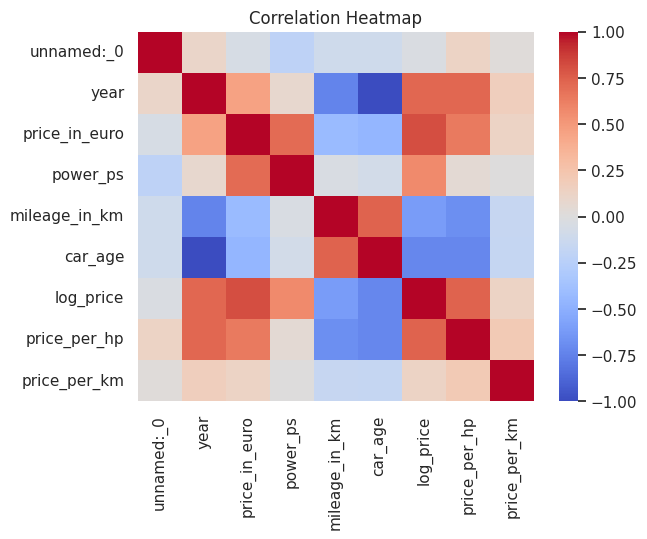

In [137]:
# ====================================
# 5. Correlation Analysis
# ====================================
print("Price↔HP:", df["price_in_euro"].corr(df["power_ps"]))
print("Price↔Mileage:", df["price_in_euro"].corr(df["mileage_in_km"]))

sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


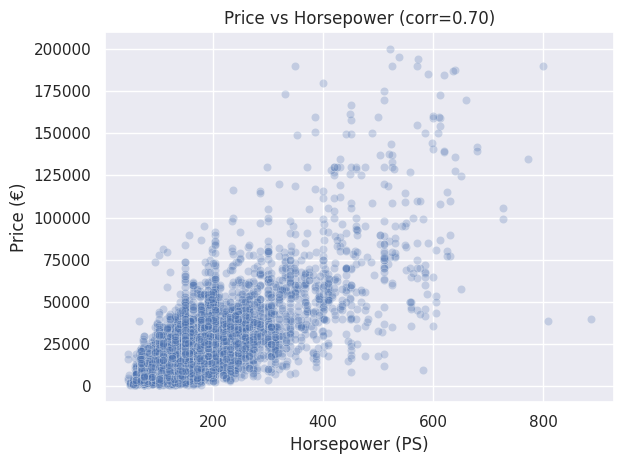

In [139]:
# === Price vs Horsepower ===
sample_hp = df.sample(min(len(df), 8000), random_state=42)
ax = sns.scatterplot(data=sample_hp, x="power_ps", y="price_in_euro", alpha=0.25)
finalize(ax,
         f"Price vs Horsepower (corr={df['price_in_euro'].corr(df['power_ps']):.2f})",
         "Horsepower (PS)", "Price (€)", "price_vs_hp.png")


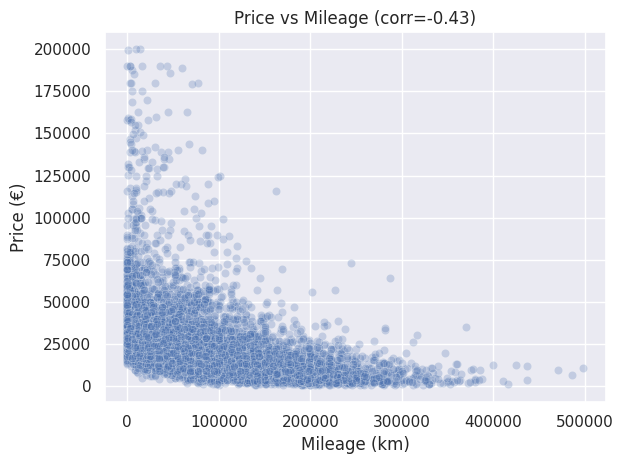

In [140]:
# === Price vs Mileage ===
sample_mi = df.sample(min(len(df), 8000), random_state=43)
ax = sns.scatterplot(data=sample_mi, x="mileage_in_km", y="price_in_euro", alpha=0.25)
finalize(ax,
         f"Price vs Mileage (corr={df['price_in_euro'].corr(df['mileage_in_km']):.2f})",
         "Mileage (km)", "Price (€)", "price_vs_mileage.png")


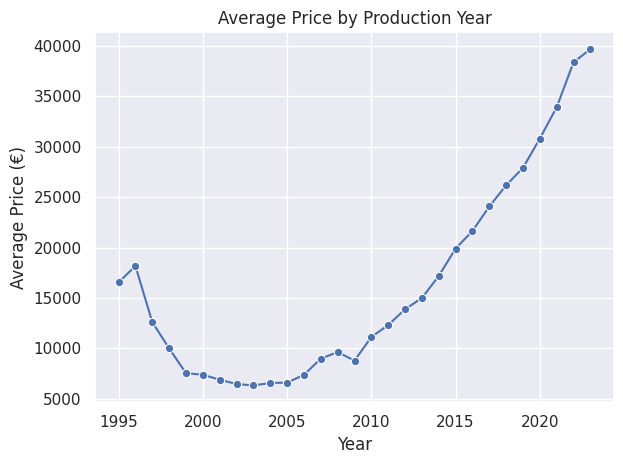

In [141]:
# ====================================
# 6. Trend Analysis
# ====================================

# Average Price by Production Year (pre-aggregated = version-proof)
avg_by_year = df.groupby("year", as_index=False)["price_in_euro"].mean().sort_values("year")
ax = sns.lineplot(x="year", y="price_in_euro", data=avg_by_year, marker="o")
finalize(ax, "Average Price by Production Year", "Year", "Average Price (€)", "avg_price_by_year.png")


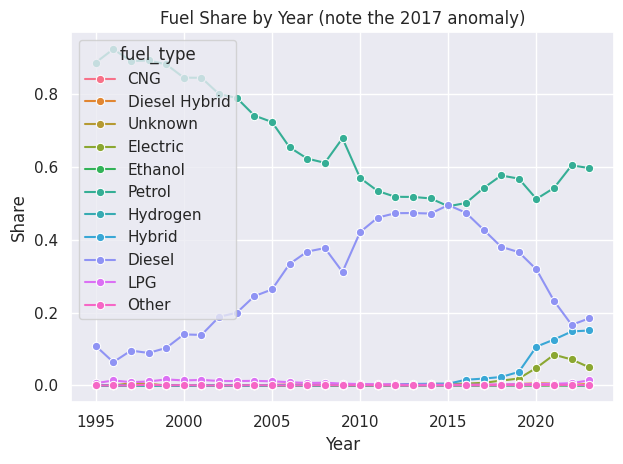

,year,fuel_type,share
283,"2,017.00",Petrol,0.54
51,"2,017.00",Diesel,0.43
167,"2,017.00",Hybrid,0.02
109,"2,017.00",Electric,0.01
225,"2,017.00",LPG,0.00
22,"2,017.00",CNG,0.00
196,"2,017.00",Hydrogen,0.00
80,"2,017.00",Diesel Hybrid,0.00
254,"2,017.00",Other,0.00
312,"2,017.00",Unknown,0.00


In [142]:
# === Fuel Share by Year (pivot-table method) ===
need = {"year","fuel_type"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns for fuel analysis: {missing}")

fuel_counts = pd.pivot_table(
    df, index="year", columns="fuel_type",
    values="price_in_euro", aggfunc="size", fill_value=0
)
fuel_share = fuel_counts.div(fuel_counts.sum(axis=1), axis=0)
fuel_year = fuel_share.reset_index().melt(
    id_vars="year", var_name="fuel_type", value_name="share"
)

ax = sns.lineplot(data=fuel_year.sort_values("year"),
                  x="year", y="share", hue="fuel_type", marker="o")
finalize(ax,
         "Fuel Share by Year (note the 2017 anomaly)",
         "Year", "Share", "fuel_share_by_year.png")

# 2017 snapshot (so you can quote numbers)
fuel_year_2017 = fuel_year.query("year == 2017").sort_values("share", ascending=False)
display(fuel_year_2017)


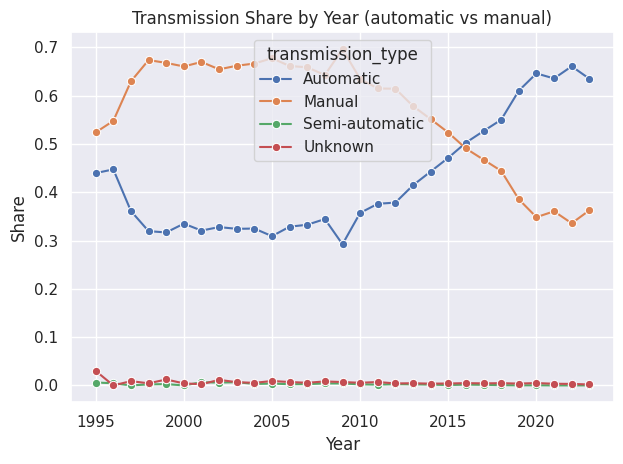

In [143]:
# === Transmission Share by Year (pivot-table method) ===
need = {"year","transmission_type"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns for transmission analysis: {missing}")

gear_counts = pd.pivot_table(
    df, index="year", columns="transmission_type",
    values="price_in_euro", aggfunc="size", fill_value=0
)
gear_share = gear_counts.div(gear_counts.sum(axis=1), axis=0)
gear_year = gear_share.reset_index().melt(
    id_vars="year", var_name="transmission_type", value_name="share"
)

ax = sns.lineplot(data=gear_year.sort_values("year"),
                  x="year", y="share", hue="transmission_type", marker="o")
finalize(ax,
         "Transmission Share by Year (automatic vs manual)",
         "Year", "Share", "transmission_share_by_year.png")


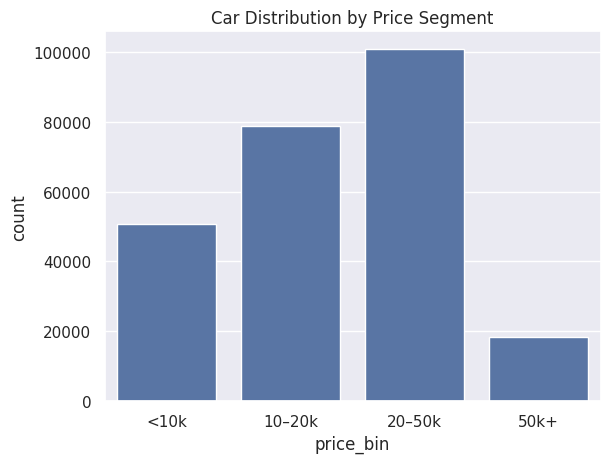

In [144]:
#  == Price segment distribution ==

bins = [0,10000,20000,50000,np.inf]
labels = ["<10k","10–20k","20–50k","50k+"]
df["price_bin"] = pd.cut(df["price_in_euro"], bins=bins, labels=labels)

sns.countplot(x="price_bin", data=df, order=labels)
plt.title("Car Distribution by Price Segment")
plt.show()


In [145]:
# ====================================
# 7. Brand and Model Statistics
# ====================================

brand_stats = df.groupby("brand")["price_in_euro"].agg(["count","mean"]).sort_values("count", ascending=False).head(15)
display(brand_stats)

df["brand_model"] = df["brand"] + " " + df["model"].astype(str)
model_stats = df.groupby("brand_model")["price_in_euro"].agg(["count","mean"]).sort_values("count", ascending=False).head(15)
display(model_stats)


,count,mean
brand,,
volkswagen,33199,"18,873.61"
mercedes-benz,26945,"28,785.70"
audi,21116,"28,255.81"
opel,20332,"14,673.77"
bmw,19744,"24,601.60"
ford,18738,"20,376.81"
skoda,14013,"22,295.70"
seat,11935,"21,925.23"
renault,8646,"17,340.93"


,count,mean
brand_model,,
volkswagen Volkswagen Golf,7579,"13,843.98"
opel Opel Astra,4358,"12,584.58"
opel Opel Corsa,4272,"11,490.24"
seat SEAT Leon,4115,"21,068.68"
ford Ford Focus,3861,"15,702.50"
skoda Skoda Octavia,3815,"21,575.39"
audi Audi A3,3564,"18,393.43"
audi Audi A4,3388,"18,722.91"
volkswagen Volkswagen Polo,3131,"10,061.31"


In [146]:
# ====================================
# 8. Predictive Modeling (Ridge Regression)
# ====================================

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV # Use RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np # Import numpy for logspace

features = ["power_ps","mileage_in_km","car_age","brand","fuel_type","transmission_type"]
target = "price_in_euro" # Define target
data = df.dropna(subset=features+[target]) # Use target variable

X, y = data[features], data[target]

pre = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), ["power_ps","mileage_in_km","car_age"]),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01), ["brand","fuel_type","transmission_type"])
])

alphas = np.logspace(-1, 2, 10) # Define alphas for RidgeCV
model = Pipeline([("pre", pre), ("ridge", RidgeCV(alphas=alphas, store_cv_results=False))]) # Use store_cv_results

Xtr, Xte, ytr, yte = train_test_split(X,y,test_size=0.2,random_state=42)
model.fit(Xtr,ytr); preds = model.predict(Xte)

print("R²:", round(r2_score(yte,preds), 3))
print("MAE (€):", round(mean_absolute_error(yte,preds), 0))
print("Chosen alpha:", model.named_steps["ridge"].alpha_) # Print chosen alpha

R²: 0.721
MAE (€): 6289.0
Chosen alpha: 2.1544346900318834


In [147]:
print("Correlation price↔HP:", round(df["price_in_euro"].corr(df["power_ps"]), 3))
print("Correlation price↔mileage:", round(df["price_in_euro"].corr(df["mileage_in_km"]), 3))

# 2017 fuel mix snapshot (only if fuel_year exists)
try:
    display(fuel_year.query("year == 2017").sort_values("share", ascending=False))
except Exception as e:
    print("Note: fuel_year not in scope yet or 2017 not present. This is optional.")


Correlation price↔HP: 0.704
Correlation price↔mileage: -0.427


,year,fuel_type,share
283,"2,017.00",Petrol,0.54
51,"2,017.00",Diesel,0.43
167,"2,017.00",Hybrid,0.02
109,"2,017.00",Electric,0.01
225,"2,017.00",LPG,0.00
22,"2,017.00",CNG,0.00
196,"2,017.00",Hydrogen,0.00
80,"2,017.00",Diesel Hybrid,0.00
254,"2,017.00",Other,0.00
312,"2,017.00",Unknown,0.00


In [148]:
# ====================================
# 9. Save Outputs
# ====================================

df.to_csv("/content/germany_used_cars_clean.csv", index=False)
print("Saved cleaned data to /content/germany_used_cars_clean.csv")
print("Saved figures to", FIGDIR.resolve())


Saved cleaned data to /content/germany_used_cars_clean.csv
Saved figures to /content/figures


## 10. Conclusions
- Price strongly correlates with horsepower (r = 0.70).
- Mileage negatively impacts price (r = -0.43).
- In 2017, diesel peaked (43%) while petrol dipped (54%), showing a market anomaly.
- Automatics overtook manuals after 2018.
- Ridge regression baseline achieved R² = 0.72 and MAE ≈ €6,300, giving a solid predictive benchmark.
